In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [27]:
print("Available columns:", df.columns.tolist())


Available columns: ['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'is_high_risk']


In [25]:
# Load the data with RFM features and target variable
df = pd.read_csv('/content/rfm_with_target.csv')
print(f"Data shape: {df.shape}")
print(f"Target distribution:\n{df['is_high_risk'].value_counts()}")

Data shape: (3742, 6)
Target distribution:
is_high_risk
0    2407
1    1335
Name: count, dtype: int64


1. Information Value (IV) Calculation

In [28]:
def calculate_iv(df, feature, target):
    """Calculate Information Value for a feature"""
    # Create bins for continuous variables
    if df[feature].dtype in ['int64', 'float64']:
        # Handle cases with too many unique values for qcut
        if df[feature].nunique() > 10: # Use a threshold, e.g., 10 unique values
            try:
                df[f'{feature}_binned'] = pd.qcut(df[feature], q=5, duplicates='drop', labels=False) # Added labels=False
                bin_col = f'{feature}_binned'
            except ValueError:
                # Fallback for cases where qcut fails (e.g., too many identical values)
                print(f"Warning: Could not create 5 quantile bins for {feature}. Using feature directly.")
                bin_col = feature
        else:
             bin_col = feature # Use feature directly for low unique values
    else:
        bin_col = feature

    # Create crosstab
    crosstab = pd.crosstab(df[bin_col], df[target])

    # Handle cases where a bin has no observations in one of the target classes
    if 0 not in crosstab.columns:
        crosstab[0] = 0
    if 1 not in crosstab.columns:
        crosstab[1] = 0

    crosstab['total'] = crosstab.sum(axis=1)
    # Add a small epsilon to avoid division by zero
    crosstab['good_rate'] = (crosstab[0] + 1e-6) / (crosstab[0].sum() + 1e-6)
    crosstab['bad_rate'] = (crosstab[1] + 1e-6) / (crosstab[1].sum() + 1e-6)


    # Calculate WOE and IV
    crosstab['woe'] = np.log(crosstab['good_rate'] / crosstab['bad_rate'])
    crosstab['iv'] = (crosstab['good_rate'] - crosstab['bad_rate']) * crosstab['woe']

    return crosstab['iv'].sum(), crosstab

# Calculate IV for all features
# Using the correct capitalization for the column names
features = ['Recency', 'Frequency', 'Monetary']
iv_results = {}

for feature in features:
    iv_score, crosstab = calculate_iv(df, feature, 'is_high_risk')
    iv_results[feature] = iv_score
    print(f"{feature}: IV = {iv_score:.4f}")

# Sort features by IV
iv_df = pd.DataFrame(list(iv_results.items()), columns=['feature', 'iv'])
iv_df = iv_df.sort_values('iv', ascending=False)
print("\nFeature Selection based on IV:")
display(iv_df) # Use display for better formatting

Recency: IV = 6.1015
Frequency: IV = 1.1942
Monetary: IV = 1.4081

Feature Selection based on IV:


,feature,iv
0,Recency,6.101479
2,Monetary,1.408105
1,Frequency,1.194200


2. WOE Encoding Implementation

In [34]:
class WOEEncoder:
    def __init__(self):
        self.woe_map = {}
        self.bins_map = {} # Store bin edges for consistent transformation

    def fit(self, X, y):
        """Fit WOE encoder"""
        for col in X.columns:
            if X[col].dtype in ['int64', 'float64']:
                # Create bins for continuous variables
                if X[col].nunique() > 10: # Use a threshold
                    try:
                        # Use qcut and store the bins
                        X_binned, bins = pd.qcut(X[col], q=5, duplicates='drop', retbins=True, labels=False) # Added retbins=True, labels=False
                        self.bins_map[col] = bins
                    except ValueError:
                         print(f"Warning: Could not create 5 quantile bins for {col}. Using feature directly for fitting.")
                         X_binned = X[col]
                         self.bins_map[col] = None # Indicate no bins were created
                else:
                    X_binned = X[col]
                    self.bins_map[col] = None # Indicate no bins were created
            else:
                X_binned = X[col]
                self.bins_map[col] = None # Indicate no bins were created


            # Calculate WOE for each bin
            crosstab = pd.crosstab(X_binned, y)

            # Handle cases where a bin has no observations in one of the target classes
            if 0 not in crosstab.columns:
                crosstab[0] = 0
            if 1 not in crosstab.columns:
                crosstab[1] = 0

            # Add a small epsilon to avoid division by zero
            crosstab['good_rate'] = (crosstab[0] + 1e-6) / (crosstab[0].sum() + 1e-6)
            crosstab['bad_rate'] = (crosstab[1] + 1e-6) / (crosstab[1].sum() + 1e-6)

            crosstab['woe'] = np.log(crosstab['good_rate'] / crosstab['bad_rate'])

            self.woe_map[col] = crosstab['woe'].to_dict()

        return self

    def transform(self, X):
        """Transform features using WOE"""
        X_woe = X.copy()

        for col in X.columns:
            if col in self.woe_map:
                if self.bins_map.get(col) is not None:
                    # Use the stored bins for consistent transformation
                    try:
                         X_binned = pd.cut(X[col], bins=self.bins_map[col], include_lowest=True, labels=False) # Use cut with stored bins
                    except ValueError:
                         print(f"Warning: Could not apply bins for {col} during transformation. Using original feature.")
                         X_woe[f'{col}_woe'] = np.nan # Or handle as appropriate for your data
                         continue
                else:
                    X_binned = X[col]

                # Map WOE values, handle potential missing bins in transform
                woe_mapping = self.woe_map[col]
                # Use .get with a default (like np.nan) to handle categories in test not seen in train
                X_woe[f'{col}_woe'] = X_binned.map(woe_mapping).fillna(np.nan)


        return X_woe

# Apply WOE encoding
# Using the correct capitalization for the column names
features = ['Recency', 'Frequency', 'Monetary']
X = df[features]
y = df['is_high_risk']

# Split data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit and transform WOE
woe_encoder = WOEEncoder()
woe_encoder.fit(X_train, y_train) # Fit on training data
X_train_woe = woe_encoder.transform(X_train) # Transform training data
X_test_woe = woe_encoder.transform(X_test) # Transform testing data

print("WOE encoded features:")
display(X_train_woe.head()) # Use display for better formatting

WOE encoded features:


,Recency,Frequency,Monetary,Recency_woe,Frequency_woe,Monetary_woe
452,11,5,-0.191306,4.278396,-0.448164,-0.209457
1980,89,2,-0.104988,-3.898986,-1.079555,-0.907177
221,11,18,-0.250768,4.278396,0.862129,0.392458
1990,46,6,-0.172798,-1.818521,-0.182048,-0.209457
16,77,1,-0.013932,-3.898986,-1.079555,-0.739672


3. Feature Selection Results

Selected features based on IV > 0.1: ['Recency', 'Monetary', 'Frequency']
WOE encoded features: ['Recency_woe', 'Monetary_woe', 'Frequency_woe']


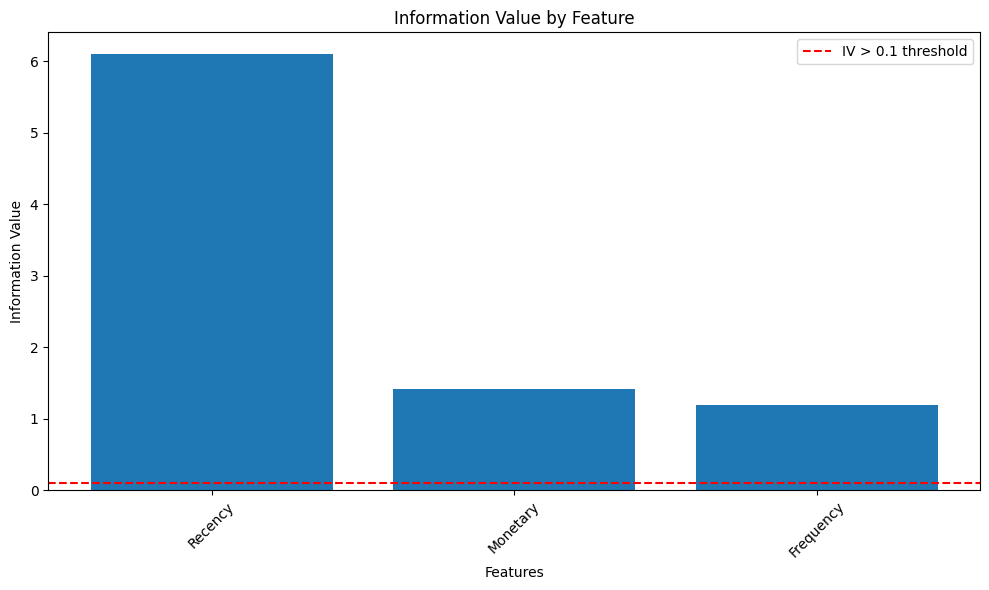

Feature selection completed and data saved!


In [31]:
# Select top features based on IV
selected_features = iv_df[iv_df['iv'] > 0.1]['feature'].tolist()
woe_features = [f'{feat}_woe' for feat in selected_features]

print(f"Selected features based on IV > 0.1: {selected_features}")
print(f"WOE encoded features: {woe_features}")

# Visualize IV scores
plt.figure(figsize=(10, 6))
plt.bar(iv_df['feature'], iv_df['iv'])
plt.title('Information Value by Feature')
plt.xlabel('Features')
plt.ylabel('Information Value')
plt.xticks(rotation=45)
plt.axhline(y=0.1, color='r', linestyle='--', label='IV > 0.1 threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Save processed data
final_features = X_train_woe[woe_features]
final_features.to_csv('features_train_woe.csv', index=False)
X_test_woe[woe_features].to_csv('features_test_woe.csv', index=False)
pd.Series(y_train).to_csv('target_train.csv', index=False)
pd.Series(y_test).to_csv('target_test.csv', index=False)

print("Feature selection completed and data saved!")